# Bayesian Fusion of Nighttime Lights, NDVI, and Road Density in Cuba
This notebook walks through an **exploratory data analysis (EDA)** and a **Bayesian hierarchical model** that estimates a latent economic activity index for Cuba on a 500 m grid.  We combine three satellite‐derived proxies:
1. **VIIRS Nighttime Lights** (`cuba_viirs_2024.tif`)
2. **NDVI** (`cuba_ndvi_2024.tif`)
3. **Road Density** (`cuba_osm_road_density_2024.tif`)

The model specification follows the project description I gave in the midterm, with a Gaussian Markov Random Field (ICAR) prior.

In [1]:
import numpy as np
import xarray as xr
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import pymc as pm
import arviz as az
from tqdm.auto import tqdm

plt.rcParams['figure.figsize'] = (8, 6)

## 1  Load and align the rasters

In [2]:
paths = {
    'lights': '/Users/chrisperez/Desktop/stat288-finalproject/data/cuba_viirs_2024.tif',
    'ndvi':   '/Users/chrisperez/Desktop/stat288-finalproject/data/cuba_ndvi_2024.tif',
    'roads':  '/Users/chrisperez/Desktop/stat288-finalproject/data/cuba_osm_road_density_2024.tif',
}

data_arrays = {}
for key, p in paths.items():
    with rasterio.open(p) as f:
        data_arrays[key] = xr.DataArray(
            f.read(1, masked=True),
            dims=('y', 'x'),
            coords={'y': np.arange(f.height) * f.transform[4] + f.transform[5],
                    'x': np.arange(f.width)  * f.transform[0] + f.transform[2]},
            name=key
        )
print({k: da.shape for k, da in data_arrays.items()})

{'lights': (753, 2409), 'ndvi': (753, 2409), 'roads': (753, 2409)}


### Quick look at each proxy

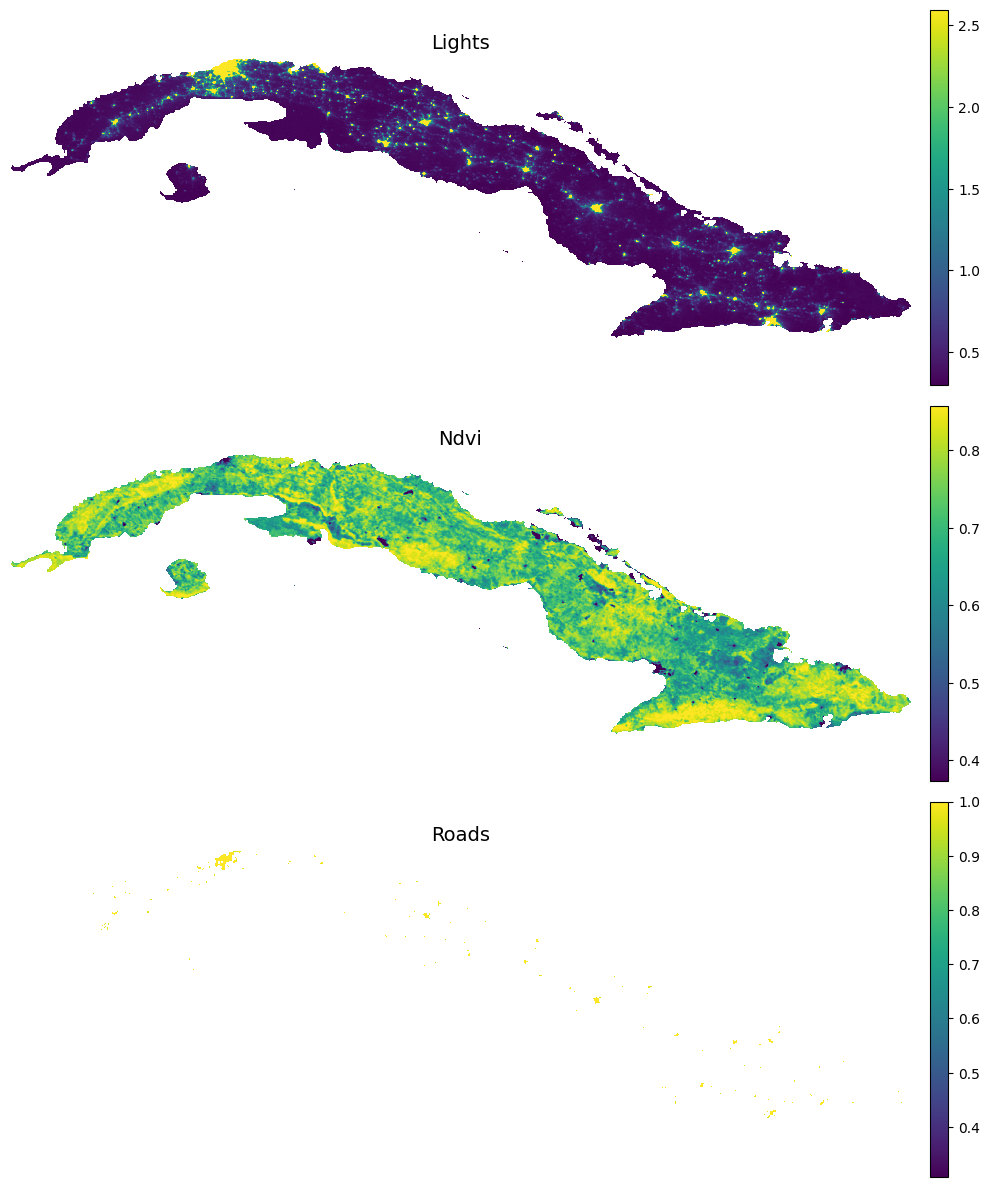

In [3]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

for ax, (k, da) in zip(axs, data_arrays.items()):
    im = ax.imshow(da, cmap='viridis', vmin=np.nanpercentile(da, 2), vmax=np.nanpercentile(da, 98))
    ax.set_title(k.capitalize(), fontsize=14)
    ax.axis('off')
    plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)

plt.tight_layout()

## 2  Mask water & standardize proxies

In [4]:
# Build a combined mask (land pixels are True)
mask = (~data_arrays['lights'].isnull()) & (~data_arrays['ndvi'].isnull()) & (~data_arrays['roads'].isnull())

stacked = xr.concat([data_arrays[k] for k in ['lights', 'ndvi', 'roads']], dim='band')
land_vals = stacked.where(mask).values  # shape (3, ny, nx)

# Flatten land pixels
ny, nx = mask.shape
land_idx = np.where(mask.values.ravel())[0]
X = np.vstack([
    data_arrays['lights'].values.ravel()[land_idx],
    data_arrays['ndvi'].values.ravel()[land_idx],
    data_arrays['roads'].values.ravel()[land_idx]
]).T  # shape (N, 3)

means = X.mean(axis=0)
stds = X.std(axis=0)
X_std = (X - means) / stds

print('Means after standardization', X_std.mean(axis=0))
print('Stds  after standardization', X_std.std(axis=0))

Means after standardization [-1.70440302e-17 -7.44887246e-16  7.07011623e-17]
Stds  after standardization [1. 1. 1.]


### Aggregate to coarser grid to speed up sampling (15 km coarseness first)

In [6]:
coarsen = 30  # 30×30 of 500 m ≈ 15 km

ny_coarse = ny // coarsen
nx_coarse = nx // coarsen

# Build a map from flattened raster index → index in X_std
land_idx_to_Xrow = {idx: i for i, idx in enumerate(land_idx)}

Xc = []
valid = []

for i in range(ny_coarse):
    for j in range(nx_coarse):
        block_idxs = []
        for y in range(i * coarsen, (i + 1) * coarsen):
            for x in range(j * coarsen, (j + 1) * coarsen):
                if 0 <= y < ny and 0 <= x < nx:
                    flat_idx = y * nx + x
                    if flat_idx in land_idx_to_Xrow:
                        block_idxs.append(land_idx_to_Xrow[flat_idx])
        if block_idxs:
            sub_vals = X_std[block_idxs]
            Xc.append(sub_vals.mean(axis=0))
            valid.append((i, j))

Xc = np.vstack(Xc)
print("Coarse cells:", Xc.shape[0])

Coarse cells: 645


## 3  Construct ICAR neighbor structure

In [7]:
# Map (row, col) in coarse grid → row index in Xc
loc_to_idx = {loc: idx for idx, loc in enumerate(valid)}

# Build 4-neighbor connectivity
neighbor_pairs = []
for (i, j), idx in loc_to_idx.items():
    for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # up, down, left, right
        nbr = (i + di, j + dj)
        if nbr in loc_to_idx:
            neighbor_pairs.append((idx, loc_to_idx[nbr]))
            

# Convert to NumPy arrays
i_idx = np.array([i for i, j in neighbor_pairs])
j_idx = np.array([j for i, j in neighbor_pairs])

## 4  Bayesian hierarchical model

In [18]:
with pm.Model() as model:
    # Data
    x_obs = pm.Data("x_obs", Xc)
    N = Xc.shape[0]

    # Fixed and estimated betas
    beta_lights = 1.0
    beta_ndvi  = pm.Normal("beta_ndvi", mu=0.0, sigma=1.0)
    beta_roads = pm.Normal("beta_roads", mu=0.0, sigma=1.0)
    betas = pm.math.stack([beta_lights, beta_ndvi, beta_roads])

    # Prior on spatial precision (stabilized)
    tau = pm.HalfNormal("tau", sigma=1.0)

    # Non-centered latent field
    z_raw = pm.Normal("z_raw", mu=0.0, sigma=1.0, shape=N)
    z = z_raw / pm.math.sqrt(tau)

    # ICAR smoothing potential
    diffs = z[i_idx] - z[j_idx]
    icar_term = -0.5 * pm.math.sum(diffs**2)
    pm.Potential("icar", icar_term)

    # Observation noise
    sigma = pm.HalfNormal("sigma", sigma=1.0, shape=3)

    # Linear model
    mu = z[:, None] * betas[None, :]  # shape (N, 3)
    pm.Normal("obs", mu=mu, sigma=sigma, observed=x_obs)

    # Sample
    trace = pm.sample(1000, tune=2000, chains=4, target_accept=0.99, progressbar=True)

trace

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_ndvi, beta_roads, tau, z_raw, sigma]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 49 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [50]:
az.summary(trace, var_names=["beta_ndvi", "beta_roads", "sigma", "tau"], round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_ndvi,0.676,0.156,0.366,0.947,0.006,0.004,623.137,1919.148,1.007
beta_roads,3.061,0.136,2.797,3.305,0.021,0.015,42.268,235.210,1.075
sigma[0],0.909,0.032,0.853,0.970,0.001,0.001,805.149,1609.853,1.003
sigma[1],0.975,0.034,0.914,1.042,0.001,0.001,633.082,1228.961,1.005
sigma[2],0.075,0.054,0.015,0.167,0.021,0.016,6.388,82.914,1.712
tau,7.023,0.575,5.977,8.097,0.067,0.047,68.315,186.875,1.062


## 5  Posterior diagnostics

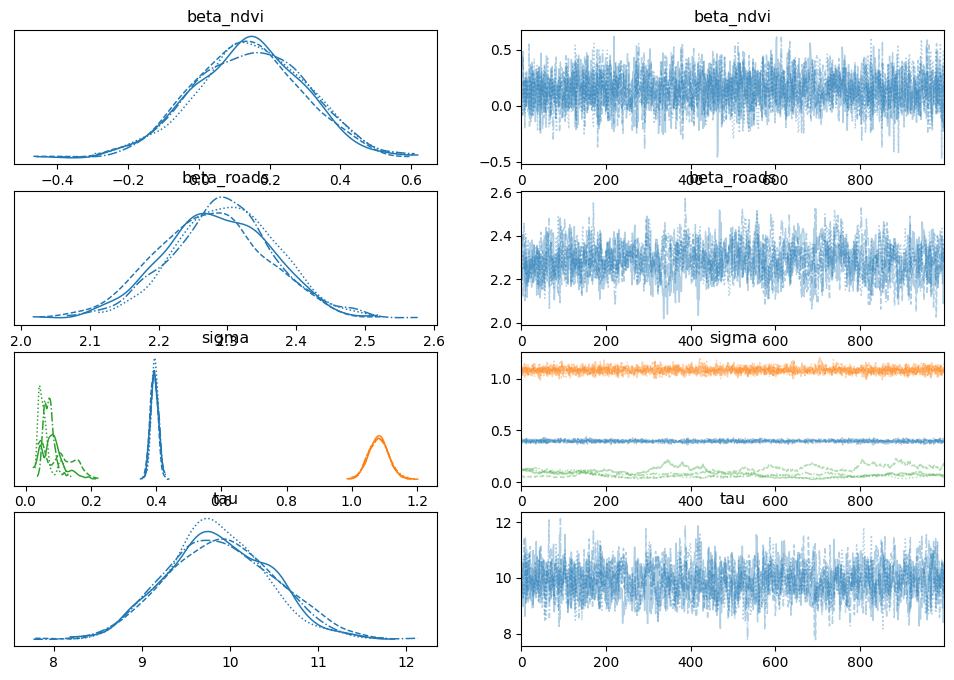

In [21]:
az.plot_trace(trace, var_names=['beta_ndvi','beta_roads','sigma','tau']);

## 6  Posterior mean latent activity map

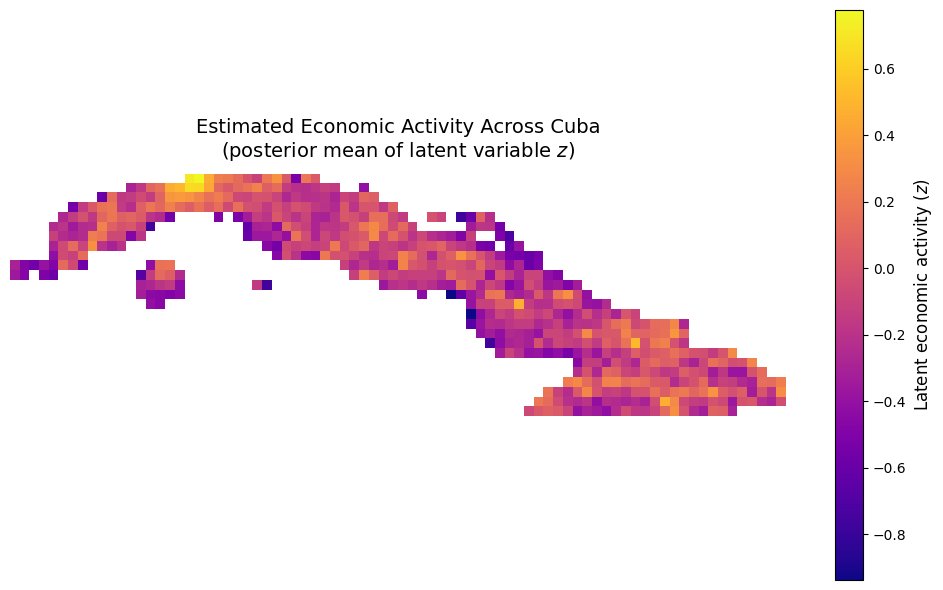

In [22]:
z_raw = trace.posterior["z_raw"].stack(samples=("chain", "draw")).values 
tau_samples = trace.posterior["tau"].stack(samples=("chain", "draw")).values 

# Rescale z_raw using the sampled tau
z = z_raw / np.sqrt(tau_samples) 

# Compute posterior mean over samples
z_mean = z.mean(axis=1)  

lat_map = np.full((ny_coarse, nx_coarse), np.nan)
for k, (r, c) in enumerate(valid):
    lat_map[r, c] = z_mean[k]

plt.figure(figsize=(10, 6))

im = plt.imshow(lat_map, cmap="plasma")
plt.title("Estimated Economic Activity Across Cuba\n(posterior mean of latent variable $z$)", fontsize=14, pad=12)
cbar = plt.colorbar(im)
cbar.set_label("Latent economic activity ($z$)", fontsize=12)

plt.axis("off") 
plt.tight_layout()
plt.show()


## QUANTIFYING UNCERTAINTY

In [23]:
z_samples = z_raw / np.sqrt(tau_samples) 
z_std = z_samples.std(axis=1)  

uncert_map = np.full((ny_coarse, nx_coarse), np.nan)
for k, (r, c) in enumerate(valid):
    uncert_map[r, c] = z_std[k]

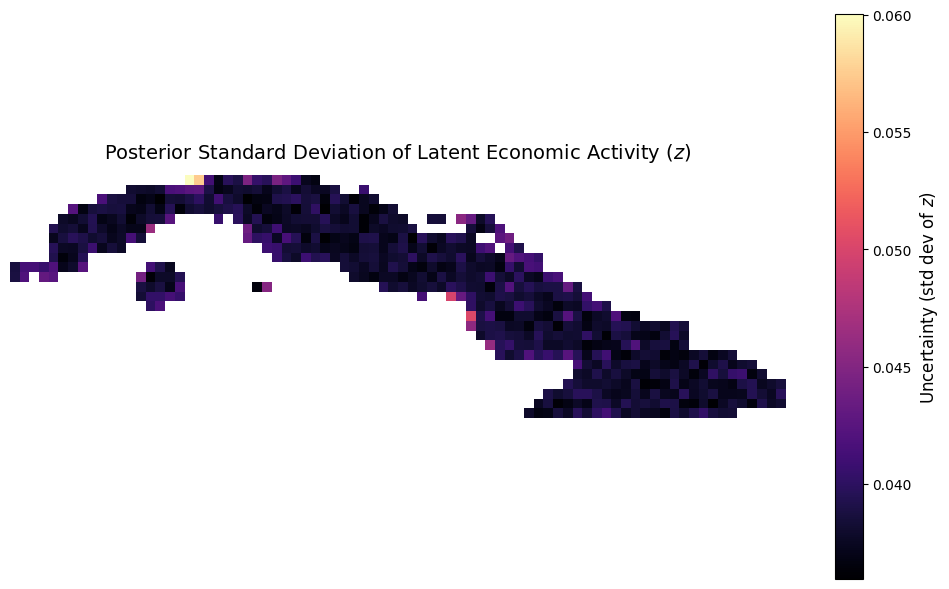

In [24]:
plt.figure(figsize=(10, 6))
im = plt.imshow(uncert_map, cmap="magma")
plt.title("Posterior Standard Deviation of Latent Economic Activity ($z$)", fontsize=14, pad=12)
cbar = plt.colorbar(im)
cbar.set_label("Uncertainty (std dev of $z$)", fontsize=12)
plt.axis("off")
plt.tight_layout()
plt.show()

## MULTI-RESOLUTION EXPERIMENT

In [31]:
BLOCK_SIZES = [10, 20, 40]       # 5 km, 10 km, 20 km
SAMPLE_KW   = dict(draws=1000, tune=2000, chains=4,
                   target_accept=0.99,
                   progressbar=True)

In [34]:
def coarsen_da(da, block):
    return (da
            .coarsen(y=block, x=block, boundary="trim")
            .mean(skipna=True))

def make_coarse_stack(block):
    da_c = {k: coarsen_da(data_arrays[k], block)
            for k in ['lights', 'ndvi', 'roads']}

    ny_c, nx_c = da_c['lights'].shape

    # Boolean mask of pixels that are valid in all three layers
    mask = np.logical_and.reduce([~da_c[k].isnull() if hasattr(da_c[k], "isnull")
                                  else ~np.isnan(da_c[k])      
                                  for k in da_c])

    mask_np = mask.values if hasattr(mask, "values") else mask  

    coords = np.argwhere(mask_np)                            

    # stack proxies for valid pixels
    X = np.stack([da_c[k].values[mask_np] if hasattr(da_c[k], "values")
                  else da_c[k][mask_np]
                  for k in ['lights', 'ndvi', 'roads']], axis=1)

    X_std = (X - X.mean(0)) / X.std(0)
    return X_std.astype(np.float32), coords, (ny_c, nx_c)


def neighbour_pairs(coords):
    loc_to_idx = {tuple(rc): i for i, rc in enumerate(coords)}
    pairs = []
    for (r,c), idx in loc_to_idx.items():
        for dr,dc in [(-1,0),(1,0),(0,-1),(0,1)]:
            nbr = (r+dr, c+dc)
            if nbr in loc_to_idx:
                pairs.append((idx, loc_to_idx[nbr]))
    i_idx = np.array([i for i,j in pairs])
    j_idx = np.array([j for i,j in pairs])
    return i_idx, j_idx

In [35]:
results = []
for block in BLOCK_SIZES:
    print(f"\n=== Coarseness block = {block} ({block*0.5:.1f} km) ===")
    Xc, coords, (ny_c, nx_c) = make_coarse_stack(block)
    i_idx, j_idx = neighbour_pairs(coords)
    N = Xc.shape[0]

    with pm.Model() as m:
        # data
        x_obs = pm.Data("x_obs", Xc)
        # coefficients
        beta_ndvi  = pm.Normal("beta_ndvi", 0, 1)
        beta_roads = pm.Normal("beta_roads", 0, 1)
        betas = pm.math.stack([1.0, beta_ndvi, beta_roads])
        # precision
        tau = pm.HalfNormal("tau", 1.0)
        # non‑centred latent
        z_raw = pm.Normal("z_raw", 0, 1, shape=N)
        z = z_raw / pm.math.sqrt(tau)
        diffs = z[i_idx] - z[j_idx]
        pm.Potential("icar", -0.5 * pm.math.sum(diffs**2))
        
        sigma = pm.HalfNormal("sigma", sigma=1.0, shape=3)
        
        # likelihood
        mu = z[:,None] * betas[None,:]
        pm.Normal("obs", mu=mu, sigma=sigma, observed=x_obs)
        # sample
        trace = pm.sample(**SAMPLE_KW)

    # posterior latent stats
    z_samples = (trace.posterior["z_raw"] /
                 np.sqrt(trace.posterior["tau"])).stack(
                 sample=("chain","draw")).values
    z_mean = z_samples.mean(1)
    z_std  = z_samples.std(1)

    results.append(dict(
        block=block,
        trace=trace,
        z_mean=z_mean,
        z_std=z_std,
        coords=coords,
        ny=ny_c, nx=nx_c
    ))


=== Coarseness block = 10 (5.0 km) ===


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_ndvi, beta_roads, tau, z_raw, sigma]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 294 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...



=== Coarseness block = 20 (10.0 km) ===


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_ndvi, beta_roads, tau, z_raw, sigma]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 121 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...



=== Coarseness block = 40 (20.0 km) ===


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_ndvi, beta_roads, tau, z_raw, sigma]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 45 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [48]:
summary = pd.DataFrame({
    "block":      [r["block"] for r in results],
    "cells":      [len(r["z_mean"]) for r in results],
    "var_z":      [r["z_mean"].var() for r in results],
    "mean_post_std": [r["z_std"].mean() for r in results],

    # proxy loadings
    "beta_ndvi":  [float(r["trace"].posterior["beta_ndvi"].mean())  for r in results],
    "beta_roads": [float(r["trace"].posterior["beta_roads"].mean()) for r in results],

    # noise scales  σ₀ (lights)  σ₁ (NDVI)  σ₂ (roads)
    "sigma_lights": [float(r["trace"].posterior["sigma"][:,:,0].mean()) for r in results],
    "sigma_ndvi":   [float(r["trace"].posterior["sigma"][:,:,1].mean()) for r in results],
    "sigma_roads":  [float(r["trace"].posterior["sigma"][:,:,2].mean()) for r in results],

    # spatial precision and diagnostics
    "tau":         [float(r["trace"].posterior["tau"].mean()) for r in results],
    "divergences": [int(r["trace"].sample_stats["diverging"].sum())  for r in results],
})

display(summary.style.format("{:.3f}"))


,block,cells,var_z,mean_post_std,beta_ndvi,beta_roads,sigma_lights,sigma_ndvi,sigma_roads,tau,divergences
0,10.000,4707.000,0.050,0.023,-0.276,4.440,0.946,0.998,0.097,17.389,0.000
1,20.000,1321.000,0.072,0.023,0.425,3.703,0.940,0.995,0.075,11.142,0.000
2,40.000,378.000,0.105,0.033,0.676,3.061,0.909,0.975,0.075,7.023,0.000


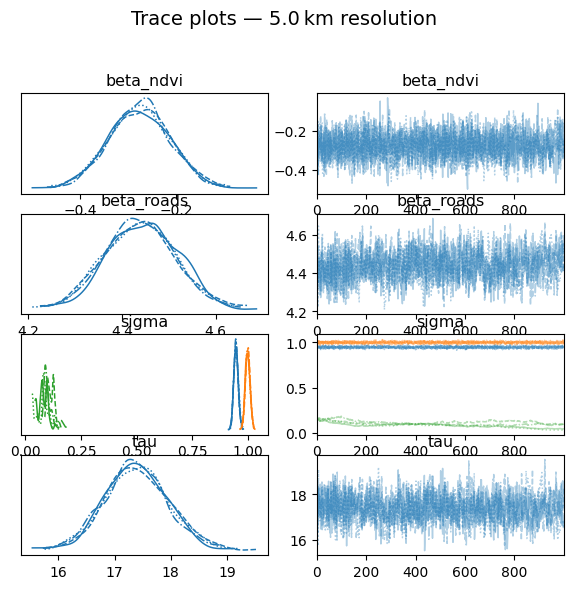

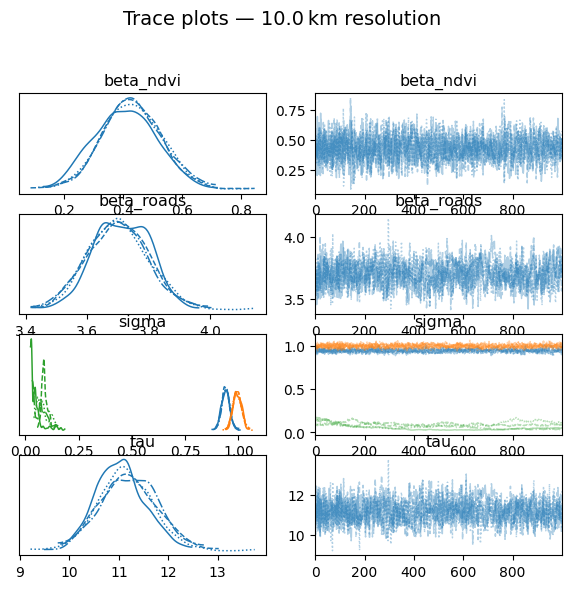

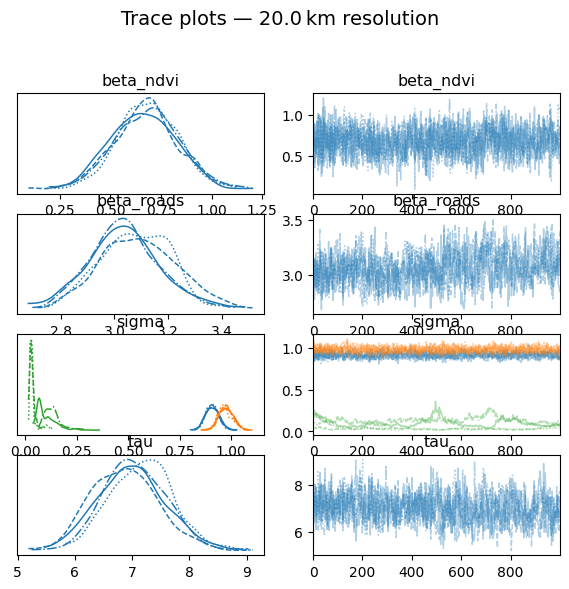

In [45]:
import matplotlib.pyplot as plt

for r in results:
    km = r["block"] * 0.5          # each fine pixel is 0.5 km (500 m)
    az.plot_trace(
        r["trace"],
        var_names=["beta_ndvi", "beta_roads", "sigma", "tau"],
        compact=True,
        figsize=(7, 6),
    )
    plt.gcf().suptitle(
        f"Trace plots — {km:.1f} km resolution",
        y=1.02, fontsize=14
    )
    plt.show()


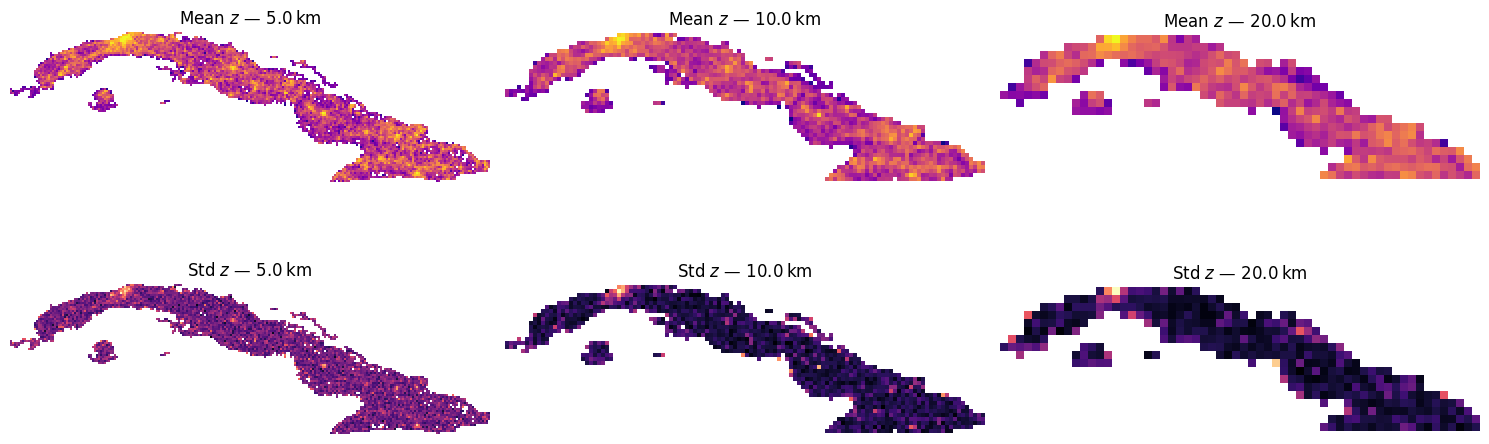

In [47]:
fig, axs = plt.subplots(2, len(results), figsize=(5*len(results), 6))

for j, r in enumerate(results):
    nyc, nxc = r["ny"], r["nx"]
    g_mean   = np.full((nyc, nxc), np.nan)
    g_std    = np.full_like(g_mean, np.nan)
    for k, (rr, cc) in enumerate(r["coords"]):
        g_mean[rr, cc] = r["z_mean"][k]
        g_std [rr, cc] = r["z_std"][k]

    km = r["block"] * 0.5           # 1 pixel = 0.5 km

    axs[0, j].imshow(g_mean, cmap="plasma")
    axs[0, j].set_title(
        f"Mean $z$ — {km:.1f} km",
        fontsize=12
    )
    axs[0, j].axis("off")

    axs[1, j].imshow(g_std, cmap="magma")
    axs[1, j].set_title(
        f"Std $z$ — {km:.1f} km",
        fontsize=12
    )
    axs[1, j].axis("off")

plt.tight_layout()

## VISUALIZING IN SPECIFIC AREAS OF CUBA

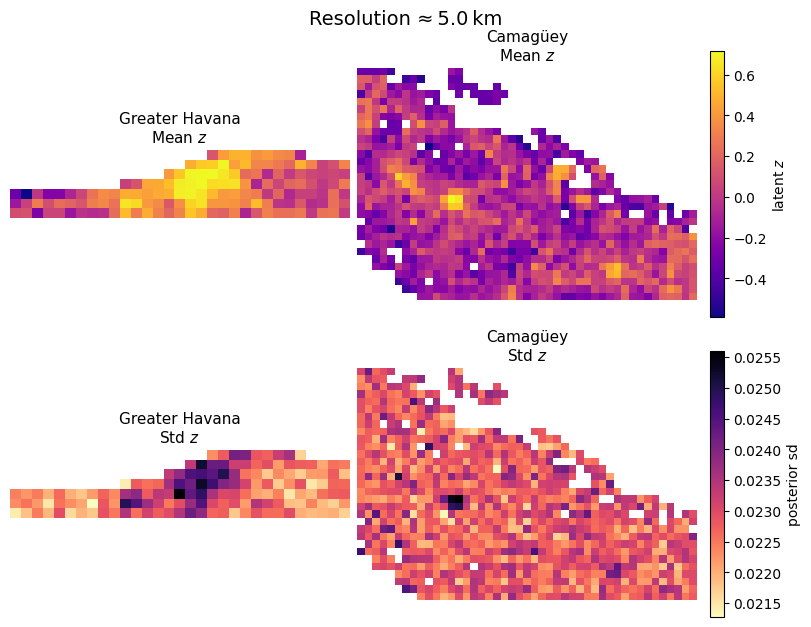

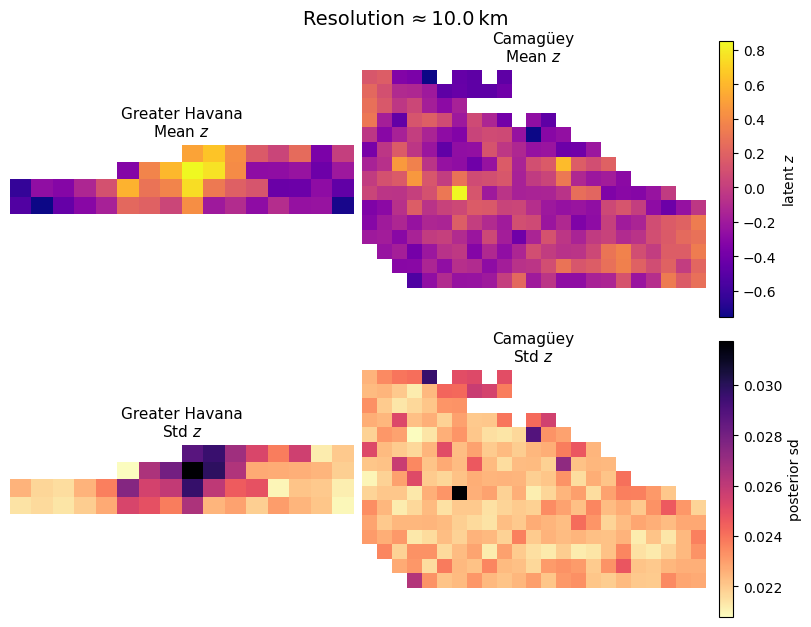

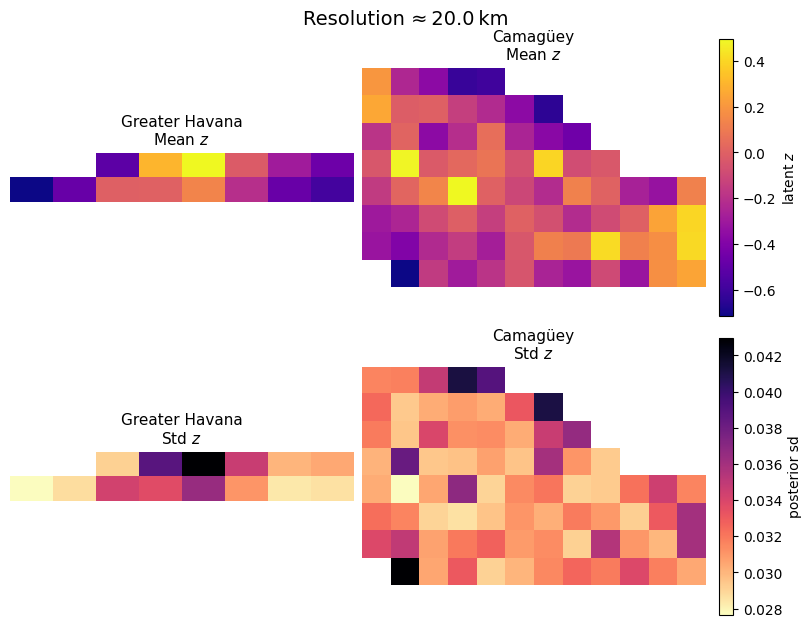

In [53]:
# -- bounding boxes: (lon_min, lon_max, lat_min, lat_max)
bbox_dict = {
    "Greater Havana": (-83.20, -81.80, 22.9, 23.5),
    "Camagüey":       (-78.50, -76.50, 20.8, 22.2),
}

# helper: coarse lon/lat for a given block
def coarse_coords(block):
    da_ref = data_arrays["lights"]          # any 500 m DataArray with .x & .y
    lon_c = da_ref.x.values[::block][: da_ref.x.shape[0] // block]
    lat_c = da_ref.y.values[::block][: da_ref.y.shape[0] // block]
    return lon_c, lat_c                    # 1‑D arrays: (nx_c,) , (ny_c,)

def idx_from_bbox(lon_c, lat_c, bbox):
    lon_min, lon_max, lat_min, lat_max = bbox
    cols = np.where((lon_c >= lon_min) & (lon_c <= lon_max))[0]
    rows = np.where((lat_c >= lat_min) & (lat_c <= lat_max))[0]
    return rows, cols

for r in sorted(results, key=lambda d: d["block"]):     # order by block
    block = r["block"]
    km    = block * 0.5
    lon_c, lat_c = coarse_coords(block)

    nyc, nxc = r["ny"], r["nx"]
    grid_mean = np.full((nyc, nxc), np.nan)
    grid_std  = np.full_like(grid_mean, np.nan)
    for k, (rr, cc) in enumerate(r["coords"]):
        grid_mean[rr, cc] = r["z_mean"][k]
        grid_std [rr, cc] = r["z_std"][k]

    # one figure per resolution
    n_reg = len(bbox_dict)
    fig, axes = plt.subplots(2, n_reg, figsize=(4*n_reg, 6),
                             constrained_layout=True)

    for col, (region, bbox) in enumerate(bbox_dict.items()):
        rows, cols = idx_from_bbox(lon_c, lat_c, bbox)
        mean_sub = grid_mean[np.ix_(rows, cols)]
        std_sub  = grid_std [np.ix_(rows, cols)]

        # posterior mean
        im1 = axes[0, col].imshow(mean_sub, cmap="plasma",
                                  extent=[cols.min(), cols.max(),
                                          rows.max(), rows.min()])
        axes[0, col].set_title(f"{region}\nMean $z$", fontsize=11)
        axes[0, col].axis("off")

        # posterior std
        im2 = axes[1, col].imshow(std_sub, cmap="magma_r",
                                  extent=[cols.min(), cols.max(),
                                          rows.max(), rows.min()])
        axes[1, col].set_title(f"{region}\nStd $z$", fontsize=11)
        axes[1, col].axis("off")

    # shared color‑bars
    fig.colorbar(im1, ax=axes[0, :], fraction=0.03, pad=0.02,
                 label="latent $z$")
    fig.colorbar(im2, ax=axes[1, :], fraction=0.03, pad=0.02,
                 label="posterior sd")

    fig.suptitle(f"Resolution ≈ {km:.1f} km",
                 fontsize=14, y=1.02)
    plt.show()
